In [1]:
import models
import os
import torch
from torch import optim, nn
from torchvision import transforms, datasets
import torchvision
import common
import matplotlib.pyplot as plt

In [2]:
#DIRECTORY SETTINGS
os.chdir("..")#Go up two directories
SAVE_DIR = 'models'
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, 'dual_gpu.pt')


#HYPERPARAMETERS
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCHS=100
BATCH_SIZE = 32
criterion = nn.CrossEntropyLoss()
ADAM_OPTIMISER=True
LEARNING_RATE=0.001

In [3]:
train_transforms = transforms.Compose([# Data Transforms
                           transforms.Resize(256),#Resize
                           transforms.RandomHorizontalFlip(30),#Flip
                           transforms.RandomRotation(10),#Roatate
                           transforms.RandomCrop(256),#Crop
                           transforms.ToTensor(),#Convert to Tensor
                           transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))#Normalize
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
                       ])

In [4]:
train_data = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=train_transforms)#Use CIFAR10 to train
train_data, valid_data = torch.utils.data.random_split(train_data, [int(len(train_data)*0.9), len(train_data) - int(len(train_data)*0.9)])
test_data = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=test_transforms)


print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')


train_iterator = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_iterator = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


In [5]:
model = torchvision.models.resnet18(pretrained=True)#TorchVision

for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)
model = nn.DataParallel(model)

#Hyperparameters
if(ADAM_OPTIMISER):
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
else:
    optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.5)

0
| Epoch: 01 | Train Loss: 1.054 | Train Acc: 64.90% | Val. Loss: 0.799 | Val. Acc: 72.83% |
1
| Epoch: 02 | Train Loss: 0.842 | Train Acc: 71.29% | Val. Loss: 0.722 | Val. Acc: 75.32% |
2
| Epoch: 03 | Train Loss: 0.802 | Train Acc: 72.48% | Val. Loss: 0.717 | Val. Acc: 75.76% |
3
| Epoch: 04 | Train Loss: 0.794 | Train Acc: 72.65% | Val. Loss: 0.706 | Val. Acc: 76.07% |
4
| Epoch: 05 | Train Loss: 0.779 | Train Acc: 73.06% | Val. Loss: 0.690 | Val. Acc: 77.19% |
5
| Epoch: 06 | Train Loss: 0.781 | Train Acc: 72.97% | Val. Loss: 0.708 | Val. Acc: 76.23% |
6
| Epoch: 07 | Train Loss: 0.774 | Train Acc: 73.24% | Val. Loss: 0.715 | Val. Acc: 75.78% |
7
| Epoch: 08 | Train Loss: 0.771 | Train Acc: 73.63% | Val. Loss: 0.727 | Val. Acc: 75.38% |
8
| Epoch: 09 | Train Loss: 0.770 | Train Acc: 73.53% | Val. Loss: 0.695 | Val. Acc: 76.33% |
9
| Epoch: 10 | Train Loss: 0.766 | Train Acc: 73.63% | Val. Loss: 0.712 | Val. Acc: 76.51% |
10
| Epoch: 11 | Train Loss: 0.761 | Train Acc: 73.88% | Val

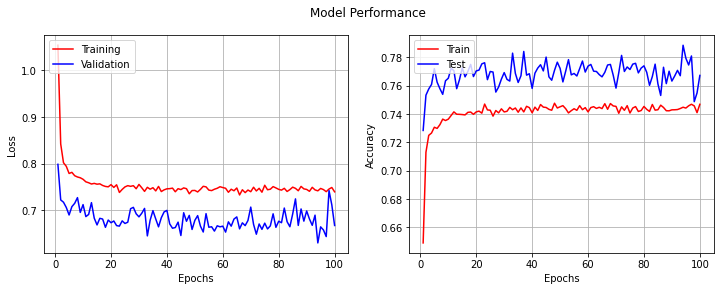

In [6]:
#Train
best_valid_loss = float('inf')
epoch_hist = [] # List to store epochs
train_loss_hist = [] # List to store training loss
train_acc_hist = [] # List to store training accuracy
valid_loss_hist = [] # List to store validation loss
valid_acc_hist = [] # List to store validation accuracy
for epoch in range(EPOCHS):#Range of Epochs
    print(epoch)
    train_loss, train_acc = common.train(model, device, train_iterator, optimizer, criterion)#Train Loss Calculation
    valid_loss, valid_acc = common.evaluate(model, device, valid_iterator, criterion)#Validation Loss Calculation
    epoch_hist.append(epoch+1) # Append epoch
    train_loss_hist.append(train_loss) # Append training loss
    train_acc_hist.append(train_acc) # Append training accuracy
    valid_loss_hist.append(valid_loss) # Append validation loss
    valid_acc_hist.append(valid_acc) # Append validation accuracy

    if valid_loss < best_valid_loss:#Validation Loss - Is current lower than the saved validation loss.
        best_valid_loss = valid_loss#Save the best loss (lowest)
        torch.save(model.state_dict(), MODEL_SAVE_PATH)#Save the model

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:05.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:05.2f}% |')

# Plot loss and accuracy plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4)) # Create side-by-side subplots
fig.suptitle('Model Performance') # Common plot title
# Plot loss curves
ax1.plot(epoch_hist, train_loss_hist, label='Training', color='red') # Plot training loss
ax1.plot(epoch_hist, valid_loss_hist, label='Validation', color='blue') # Plot validation loss
ax1.legend(loc='upper left') # Show legend
ax1.set_xlabel('Epochs') # Show label for X-axis
ax1.set_ylabel('Loss') # Show label for Y-axis
ax1.grid(True) # Show grid
# Plot accuracy curves
ax2.plot(epoch_hist, train_acc_hist, label='Train', color='red') # Plot training accuracy
ax2.plot(epoch_hist, valid_acc_hist, label='Test', color='blue') # Plot validation accuracy
ax2.legend(loc='upper left') # Show legend
ax2.set_xlabel('Epochs') # Show label for X-axis
ax2.set_ylabel('Accuracy') # Show label for Y-axis
ax2.grid(True) # Show grid

In [7]:
model.load_state_dict(torch.load(MODEL_SAVE_PATH)) #Load best weights from file
test_loss, test_acc = common.evaluate(model, device, valid_iterator, criterion) #Test Loss is dependent on
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:05.2f}%')

| Test Loss: 0.652 | Test Acc: 77.59%
